In [1]:
#Install Required Libraries
!pip install transformers torch pandas numpy scikit-learn


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2Config
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Dataset Class Definition
class PricingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [4]:
# Model Architecture
class GenAIPricingTransformer(nn.Module):
    def __init__(self, input_dim, n_heads=8, n_layers=6, dropout=0.1):
        super().__init__()

        self.config = GPT2Config(
            vocab_size=1,
            n_positions=input_dim,
            n_ctx=input_dim,
            n_embd=256,
            n_layer=n_layers,
            n_head=n_heads,
            n_inner=1024,
            activation_function='gelu',
            resid_pdrop=dropout,
            embd_pdrop=dropout,
            attn_pdrop=dropout,
            scale_attn_weights=True
        )

        self.feature_embedding = nn.Linear(input_dim, 256)
        self.transformer = GPT2Model(self.config)

        self.price_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

        self.market_head = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

        self.elasticity_head = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.feature_embedding(x)
        transformer_out = self.transformer(inputs_embeds=embedded.unsqueeze(1)).last_hidden_state

        price_pred = self.price_head(transformer_out.squeeze(1))
        market_pred = self.market_head(transformer_out.squeeze(1))
        elasticity_pred = self.elasticity_head(transformer_out.squeeze(1))

        return price_pred, market_pred, elasticity_pred

In [5]:
def normalize_prices(prices, min_price=1e-8):
    """Normalize prices to prevent numerical instability"""
    return np.clip(prices, min_price, None)


In [23]:
class GenAIPricingStrategy:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.min_price = 1e-8

        train_losses = []
        val_losses = []
        learning_rates = []

        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0


    def preprocess_features(self, df):
        processed_df = df.copy()

        # Normalize prices first
        price_columns = ['price', 'payment_value']
        for col in price_columns:
            if col in processed_df.columns:
                processed_df[col] = normalize_prices(processed_df[col], self.min_price)

        # Handle datetime features
        datetime_cols = ['order_purchase_timestamp', 'order_approved_at',
                         'order_delivered_carrier_date', 'order_delivered_customer_date']

        for col in datetime_cols:
            if col in processed_df.columns:
                processed_df[col] = pd.to_datetime(processed_df[col])
                processed_df[f'{col}_hour'] = processed_df[col].dt.hour
                processed_df[f'{col}_day'] = processed_df[col].dt.day
                processed_df[f'{col}_month'] = processed_df[col].dt.month

        # Create basic features with numerical stability
        processed_df['product_volume'] = (
            processed_df['product_length_cm'].clip(lower=0.1) *
            processed_df['product_height_cm'].clip(lower=0.1) *
            processed_df['product_width_cm'].clip(lower=0.1)
        )

        # Market features
        processed_df['market_density'] = processed_df.groupby('product_category_name')['seller_id'].transform('nunique')
        processed_df['category_demand'] = processed_df.groupby('product_category_name')['order_id'].transform('count')

        # Price features with numerical stability
        processed_df['price_per_weight'] = (
            processed_df['price'] / processed_df['product_weight_g'].clip(lower=0.1)
        ).clip(lower=self.min_price)

        processed_df['price_per_volume'] = (
            processed_df['price'] / processed_df['product_volume'].clip(lower=0.1)
        ).clip(lower=self.min_price)

        # Log transform price-related features
        price_related_cols = ['price', 'price_per_weight', 'price_per_volume']
        for col in price_related_cols:
            if col in processed_df.columns:
                processed_df[f'{col}_log'] = np.log1p(processed_df[col])

        # Encode categorical variables
        cat_columns = ['product_category_name', 'customer_state', 'seller_state']
        for col in cat_columns:
            if col in processed_df.columns:
                le = LabelEncoder()
                processed_df[col] = le.fit_transform(processed_df[col].astype(str))
                self.label_encoders[col] = le

        return processed_df

    def prepare_features(self, df):
        feature_columns = [
            'payment_sequential', 'payment_installments', 'product_weight_g',
            'price_per_weight_log', 'price_per_volume_log', 'category_demand',
            'market_density', 'product_photos_qty', 'product_volume',
            'product_category_name'
        ]

        X = df[feature_columns].values
        # Handle any remaining infinite or NaN values
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
        X = self.scaler.fit_transform(X)
        return X

    def train(self, features, targets, epochs=30, batch_size=32):
        train_losses = []
        val_losses = []
        learning_rates = []

        # Prepare targets
        targets = normalize_prices(targets)
        targets = np.log1p(targets)  # Log transform targets

        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            features, targets, test_size=0.2, random_state=42
        )

        # Create datasets
        train_dataset = PricingDataset(X_train, y_train)
        val_dataset = PricingDataset(X_val, y_val)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Initialize model
        self.model = GenAIPricingTransformer(input_dim=features.shape[1]).to(self.device)

        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=0.01)

        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )

        # Gradient clipping value
        max_grad_norm = 1.0

        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0

            for batch_features, batch_targets in train_loader:
                batch_features = batch_features.to(self.device)
                batch_targets = batch_targets.to(self.device)

                optimizer.zero_grad()

                try:
                    price_pred, _, _ = self.model(batch_features)
                    loss = criterion(price_pred, batch_targets)

                    if not torch.isfinite(loss):
                        print(f"Warning: Non-finite loss detected: {loss.item()}")
                        continue

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_grad_norm)
                    optimizer.step()
                    train_loss += loss.item()

                except RuntimeError as e:
                    print(f"Error in batch: {e}")
                    continue

            # Validation
            self.model.eval()
            val_loss = 0

            with torch.no_grad():
                for batch_features, batch_targets in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_targets = batch_targets.to(self.device)

                    price_pred, _, _ = self.model(batch_features)
                    batch_loss = criterion(price_pred, batch_targets)

                    if torch.isfinite(batch_loss):
                        val_loss += batch_loss.item()

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            learning_rates.append(optimizer.param_groups[0]["lr"])

            # Learning rate scheduling
            scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], '
                      f'Train Loss: {avg_train_loss:.4f}, '
                      f'Val Loss: {avg_val_loss:.4f}, '
                      f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates
        }


In [24]:
df = pd.read_csv('df_sampled_olist.csv')


In [25]:
# Cell for training and visualization
def plot_training_metrics(training_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(training_history['train_losses'], label='Training Loss', color='blue')
    ax1.plot(training_history['val_losses'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot learning rate
    ax2.plot(training_history['learning_rates'], color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True)
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Metrics:")
    print(f"Final Training Loss: {training_history['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {training_history['val_losses'][-1]:.4f}")
    print(f"Best Validation Loss: {min(training_history['val_losses']):.4f}")

    # Calculate loss reduction
    initial_loss = training_history['train_losses'][0]
    final_loss = training_history['train_losses'][-1]
    loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
    print(f"\nLoss Reduction: {loss_reduction:.2f}%")

    return min(training_history['val_losses'])

In [26]:
# Custom batch size and epochs
pricing_strategy = GenAIPricingStrategy()



In [27]:
# Preprocess data
processed_df = pricing_strategy.preprocess_features(df)


In [28]:
# Prepare features and targets
X = pricing_strategy.prepare_features(processed_df)
y = processed_df['price'].values

In [29]:
# Train model and get history
training_history = pricing_strategy.train(X, y, epochs=30, batch_size=64)


Epoch [5/30], Train Loss: 0.2178, Val Loss: 0.1358, LR: 0.001000
Epoch [10/30], Train Loss: 0.1473, Val Loss: 0.0761, LR: 0.000500
Epoch [15/30], Train Loss: 0.1201, Val Loss: 0.0508, LR: 0.000500
Epoch [20/30], Train Loss: 0.1025, Val Loss: 0.0386, LR: 0.000500
Early stopping triggered


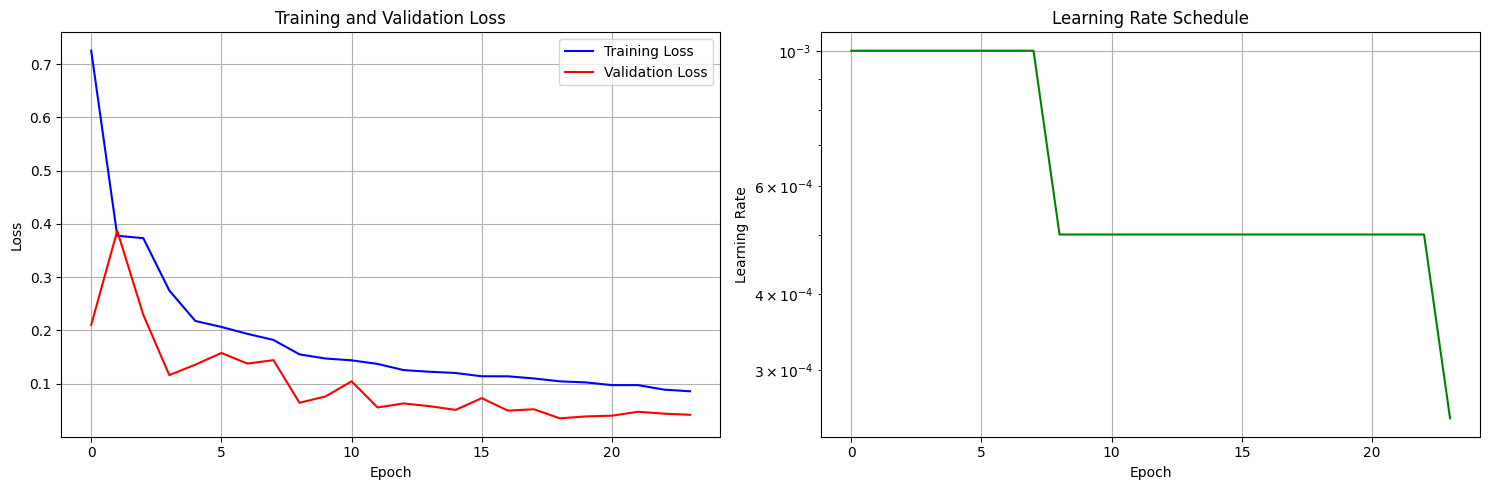


Final Metrics:
Final Training Loss: 0.0858
Final Validation Loss: 0.0416
Best Validation Loss: 0.0350

Loss Reduction: 88.17%


In [30]:
# Plot training metrics
best_val_loss = plot_training_metrics(training_history)


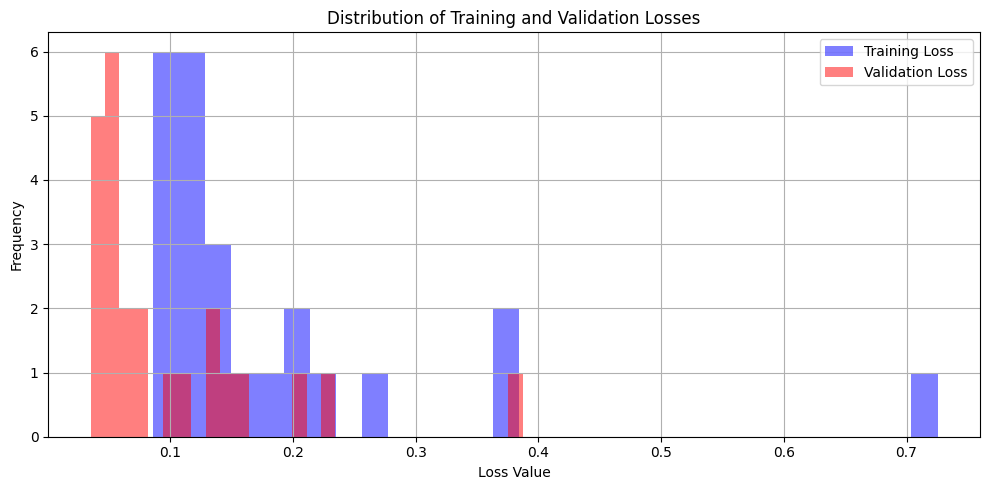

In [31]:
# Additional visualization: Loss Distribution
def plot_loss_distribution(training_history):
    plt.figure(figsize=(10, 5))

    # Create loss distribution plot
    plt.hist(training_history['train_losses'], bins=30, alpha=0.5, label='Training Loss', color='blue')
    plt.hist(training_history['val_losses'], bins=30, alpha=0.5, label='Validation Loss', color='red')

    plt.xlabel('Loss Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Training and Validation Losses')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot loss distribution
plot_loss_distribution(training_history)


In [32]:
# Create a summary of the training process
def print_training_summary(training_history):
    print("\nTraining Summary:")
    print("-" * 50)
    print(f"Number of epochs trained: {len(training_history['train_losses'])}")
    print(f"Initial training loss: {training_history['train_losses'][0]:.4f}")
    print(f"Final training loss: {training_history['train_losses'][-1]:.4f}")
    print(f"Best validation loss: {min(training_history['val_losses']):.4f}")
    print(f"Initial learning rate: {training_history['learning_rates'][0]:.6f}")
    print(f"Final learning rate: {training_history['learning_rates'][-1]:.6f}")

    # Calculate convergence metrics
    converged_epoch = training_history['val_losses'].index(min(training_history['val_losses']))
    print(f"Best model achieved at epoch: {converged_epoch + 1}")

    # Calculate stability metrics
    train_loss_std = np.std(training_history['train_losses'])
    val_loss_std = np.std(training_history['val_losses'])
    print(f"\nTraining Stability Metrics:")
    print(f"Training loss standard deviation: {train_loss_std:.4f}")
    print(f"Validation loss standard deviation: {val_loss_std:.4f}")


In [33]:
# Print training summary
print_training_summary(training_history)


Training Summary:
--------------------------------------------------
Number of epochs trained: 24
Initial training loss: 0.7253
Final training loss: 0.0858
Best validation loss: 0.0350
Initial learning rate: 0.001000
Final learning rate: 0.000250
Best model achieved at epoch: 19

Training Stability Metrics:
Training loss standard deviation: 0.1378
Validation loss standard deviation: 0.0805


In [37]:
# Get predictions for a sample product
sample_features = X[0:1]  # Example: first product in dataset
# Convert features to Tensor and move to the appropriate device
sample_features_tensor = torch.tensor(sample_features, dtype=torch.float32).to(pricing_strategy.device)

recommendations = pricing_strategy.model(sample_features_tensor)

In [39]:
print(type(recommendations))
print(recommendations)


<class 'tuple'>
(tensor([[4.1283]], grad_fn=<AddmmBackward0>), tensor([[-0.0615,  0.0810, -0.3971]], grad_fn=<AddmmBackward0>), tensor([[0.4795]], grad_fn=<SigmoidBackward0>))


In [43]:
# Assuming recommendations is a tuple of tensors
market_condition_tensor = recommendations[0]
price_elasticity_tensor = recommendations[1]
recommended_prices_tensor = recommendations[2]  # This is a tensor

# Handle market_condition tensor
if market_condition_tensor.numel() == 1:
    market_condition = market_condition_tensor.item()
else:
    market_condition = market_condition_tensor.mean().item()

# Handle price_elasticity tensor
if price_elasticity_tensor.numel() == 1:
    price_elasticity = price_elasticity_tensor.item()
else:
    price_elasticity = price_elasticity_tensor.mean().item()

# Pricing Strategy Recommendations
print("\nPricing Strategy Recommendations:")
print(f"Market Condition: {market_condition:.2f}")
print(f"Price Elasticity: {price_elasticity:.2f}")

# Handle recommended prices tensor (assuming it's a 1D tensor)
print("\nRecommended Prices:")
strategies = ['Strategy A', 'Strategy B', 'Strategy C']  # Modify this list based on your strategies
for strategy, price in zip(strategies, recommended_prices_tensor):
    print(f"{strategy}: ${price.item():.2f}")



Pricing Strategy Recommendations:
Market Condition: 4.13
Price Elasticity: -0.13

Recommended Prices:
Strategy A: $0.48


In [45]:
X[0]

array([-0.14129534,  0.09178036, -0.10479113, -0.63878242, -0.51446912,
       -0.41936586, -0.38826643, -0.09822045,  0.31956279,  0.14066501])

In [47]:
print(recommendations)


(tensor([[4.1283]], grad_fn=<AddmmBackward0>), tensor([[-0.0615,  0.0810, -0.3971]], grad_fn=<AddmmBackward0>), tensor([[0.4795]], grad_fn=<SigmoidBackward0>))


In [48]:
recommendations = (market_condition_tensor, price_elasticity_tensor, recommended_strategies_dict)


NameError: name 'recommended_strategies_dict' is not defined

In [46]:
# Create visualization of pricing strategies
strategies = list(recommendations['recommended_strategies'].keys())
prices = list(recommendations['recommended_strategies'].values())

plt.figure(figsize=(12, 6))
sns.barplot(x=strategies, y=prices)
plt.title('Pricing Strategy Recommendations')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

TypeError: tuple indices must be integers or slices, not str